[Open in Colab](https://colab.research.google.com/drive/1yeLFkTirel-T4aKWXNbAReCFfcp-sR0M?usp=sharing)

# 1. Imports Necessary Library

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import shutil
import sys
import os.path

#necessary library
!pip install -q rdkit
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs


if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
        print("install cbc")
    else:
        try:
            !conda install -c conda-forge coincbc 
            print("install cbc-2")
        except:
            print("skip cbc")
            pass
            

assert(shutil.which("cbc") or os.path.isfile("cbc"))
    
from pyomo.environ import *

# 2. Similarity Score Function

## 2.1. Similarity score of earth mover's distance for repeating units ensemble and end group ensemble 

In [ ]:
#from pyomo.common.fileutils import Executable
def Similarity_Score_EMD(query_smiles_list = None, 
                         query_smiles_level_list = None, 
                         target_smiles_list = None, 
                         target_smiles_level_list = None,
                         #level_weight = False,
                         #level_ratio = 3,
                         embedding_function = 'MorganFingerprint', #
                         similarity_score_function = 'Tanimoto', # Dice, Cosine
                         restrain_emd = False):
  
    #obtain the length of query smiles list and target smiles list
    if query_smiles_list != None:
        query_smiles_list_length = len(query_smiles_list)
    else:
        print ("Missing query smiles list")
        return    

    if target_smiles_list != None:
        target_smiles_list_length = len(target_smiles_list)
    else:
        print ("Missing target smiles list")
        return
    
    if set(query_smiles_list) == set(target_smiles_list):
        query_smiles_array = np.array(query_smiles_list)
        query_smiles_level_array = np.array(query_smiles_level_list)
        inds_query = query_smiles_array.argsort()
        sorted_query_smiles_array = query_smiles_array[inds_query]
        sorted_query_smiles_level_array = query_smiles_level_array[inds_query]

        target_smiles_array = np.array(target_smiles_list)
        target_smiles_level_array = np.array(target_smiles_level_list)
        inds_target = target_smiles_array.argsort()
        sorted_target_smiles_array = target_smiles_array[inds_target]
        sorted_target_smiles_level_array = target_smiles_level_array[inds_target]

        if np.array_equal(sorted_query_smiles_array, sorted_target_smiles_array) and np.array_equal(sorted_query_smiles_level_array, sorted_target_smiles_level_array):
            return 1

        query_smiles_reduced_list = list(set(query_smiles_list))
        query_smiles_reduced_list_number = []
        for i in range(0, len(query_smiles_reduced_list)):
            query_smiles_reduced_list_number_i  = 0
            for j in range(0, len(query_smiles_list)):
                if query_smiles_reduced_list[i] == query_smiles_list[j]:
                    query_smiles_reduced_list_number_i = query_smiles_reduced_list_number_i   + query_smiles_level_list[j]
            query_smiles_reduced_list_number.append(query_smiles_reduced_list_number_i/sum(query_smiles_level_list))

        target_smiles_reduced_list = list(set(target_smiles_list))
        target_smiles_reduced_list_number = []
        for i in range(0, len(target_smiles_reduced_list)):
            target_smiles_reduced_list_number_i  = 0
            for j in range(0, len(target_smiles_list)):
                if target_smiles_reduced_list[i] == target_smiles_list[j]:
                    target_smiles_reduced_list_number_i = target_smiles_reduced_list_number_i   + target_smiles_level_list[j]
            target_smiles_reduced_list_number.append(target_smiles_reduced_list_number_i/sum(target_smiles_level_list))

        if query_smiles_reduced_list_number == target_smiles_reduced_list_number:
            #print("check3")
            return 1.0


    Demand = {}
    Supply = {}
    T = {}

    if query_smiles_level_list == None or len(set(query_smiles_level_list)) ==1:
        for i in range(0, query_smiles_list_length):
            Demand["P" + str(i+1)] = 1/query_smiles_list_length
    else:
        print("Query smiles list has different levels")
        #query_weight_sum = sum(query_smiles_level_list)
        #level 1, weight = 1; level 2, weight = 3^1;  level n, weight = 3^n-1
        query_weight_sum = 0.0
        for i in range(0, query_smiles_list_length):
            query_weight_sum = query_weight_sum + query_smiles_level_list[i]

        for i in range(0, query_smiles_list_length):
            Demand["P" + str(i+1)] = query_smiles_level_list[i]/query_weight_sum
            #print("P" + str(i+1), Demand["P" + str(i+1)])


    if target_smiles_level_list == None or len(set(target_smiles_level_list)) ==1:       
        for j in range(0,target_smiles_list_length):
            Supply["Q" + str(j+1)] = 1/target_smiles_list_length
    else:
        print("Target smiles list has different levels")
        
        target_weight_sum = 0.0
        for j in range(0, target_smiles_list_length):
            target_weight_sum = target_weight_sum + target_smiles_level_list[j]

        for j in range(0, target_smiles_list_length):
            Supply["Q" + str(j+1)] = target_smiles_level_list[j]/target_weight_sum
            #print("Q" + str(j+1), Supply["Q" + str(j+1)])


    # embedding function and similarity 
    for i in range(0,query_smiles_list_length):
            for j in range(0,target_smiles_list_length):
                if (query_smiles_list[i] == '*H') and (target_smiles_list[j] !='*H'):

                    T[("P" + str(i+1), "Q" + str(j+1))] = 1.0

                elif (query_smiles_list[i] != '*H') and (target_smiles_list[j] =='*H'):

                    T[("P" + str(i+1), "Q" + str(j+1))] = 1.0
                
                elif (query_smiles_list[i] == '*H') and (target_smiles_list[j] =='*H'):

                    T[("P" + str(i+1), "Q" + str(j+1))] = 0.0

                elif (query_smiles_list[i] != '*H') and (target_smiles_list[j] !='*H'):
                    FP_i = 0.0 
                    FP_j = 0.0

                    if embedding_function == 'MorganFingerprint':   
                        FP_i = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(query_smiles_list[i]),2,nBits=2048)
                        FP_j = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(target_smiles_list[j]),2,nBits=2048)

                    elif embedding_function == 'RDKFingerprint': 
                        FP_i = Chem.RDKFingerprint(Chem.MolFromSmiles(query_smiles_list[i]))
                        FP_j = Chem.RDKFingerprint(Chem.MolFromSmiles(target_smiles_list[j]))
                    elif embedding_function == 'MACCSkeys':  
                        FP_i = MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(query_smiles_list[i]))
                        FP_j = MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(target_smiles_list[j]))
                    else: 
                        print(embedding_function + " is not included in the current vision, please choose an available embedding function.");
                        return False  


                # calculate the fingerprint similarityscore between query[i],target[j] and input the distance = 1- similarityscore
                    if similarity_score_function == 'Tanimoto':
                        T[("P" + str(i+1), "Q" + str(j+1))] = 1 - DataStructs.FingerprintSimilarity(FP_i, FP_j)
                        print("P" + str(i+1), "->Q" + str(j+1), T[("P" + str(i+1), "Q" + str(j+1))] )

                    elif similarity_score_function == 'Dice':
                        T[("P" + str(i+1), "Q" + str(j+1))] = 1 - DataStructs.FingerprintSimilarity(FP_i, FP_j, metric=DataStructs.DiceSimilarity)


                    elif similarity_score_function == 'Cosine':
                        T[("P" + str(i+1), "Q" + str(j+1))] = 1 - DataStructs.FingerprintSimilarity(FP_i, FP_j, metric=DataStructs.CosineSimilarity)
                    

                    else:
                        print(similarity_score_function + " is not included in the current vision, please choose an available similarity function.");
                        return

    

    #print(len(Demand), len(Supply), len(T))
    # Step 0: Create an instance of the model
    model = ConcreteModel()
    model.dual = Suffix(direction=Suffix.IMPORT)

    # Step 1: Define index sets
    CUS = list(Demand.keys())
    SRC = list(Supply.keys())

    # Step 2: Define the decision 
    model.x = Var(CUS, SRC, domain = NonNegativeReals)

    # Step 3: Define Objective
    model.Cost = Objective(
    expr = sum([T[c,s]*model.x[c,s] for c in CUS for s in SRC]),
    sense = minimize)

    # Step 4: Constraints
    model.src = ConstraintList()
    for s in SRC:
        model.src.add(sum([model.x[c,s] for c in CUS]) == Supply[s])
        
    model.dmd = ConstraintList()
    for c in CUS:
        model.dmd.add(sum([model.x[c,s] for s in SRC]) == Demand[c])

    # add restrain to the EMD
    if restrain_emd == True: 
        model.restrain = ConstraintList()
        for i in range(0,query_smiles_list_length):
            model.restrain.add(model.x[CUS[i],SRC[i]] == Supply["Q" + str(i+1)])
    
    results = SolverFactory('cbc').solve(model)


    if 'ok' == str(results.Solver.status):
        #print("EMD(P,Q) = ",model.Cost())
        #print ("\n")
        #print("S(P,Q) = ", 1- model.Cost())
        SimilarityScore = 1- model.Cost()
        return SimilarityScore
        
    else:
        print("No Valid Solution Found")
        return False


    

## 2.2. Similarity score of Graph Edit Distance

In [ ]:
# Graph Edit Distance
def Similarity_Score_Graph_Edit_Distance(Graph1 = None, 
                         Graph2 = None, 
                         alpha = 1):
    if Graph1 == None:
        print("Missing Graph1")
        return
    if Graph2 == None:
        print("Missing Graph2")
        return
    
    # Since Graph1 is the subgraph of Graph2, the calculation of graph edit distance can be simpilified.
    Graph1_number = Graph1.number_of_nodes() + Graph1.number_of_edges()
    Graph2_number = Graph2.number_of_nodes() + Graph2.number_of_edges()

    #graph_edit_distance = abs(Graph2_number - Graph1_number)
    graph_edit_distance = nx.graph_edit_distance(Graph1, Graph2)

    # utilize the exponential decay function to turn the graph edit distance to similarity score
    #similarity_score = np.exp(-alpha*graph_edit_distance/(min(Graph1_number, Graph2_number))
    similarity_score = np.exp(-alpha*graph_edit_distance/(max(Graph1_number, Graph2_number)-graph_edit_distance))

    return similarity_score 

## 2.3. Mean value with different weights and different mean functions

In [ ]:
def Combined_Similarity_Score(Repeat_Unit_Similarity_Score = None,
                              Repeat_Unit_Weight = 0.5,
                              Graph_Similarity_Score = None,
                              Graph_Weight = 0.5,
                              End_Group_Similarity_Score = None,
                              End_Group_Weight = 0.0,
                              Mean_Function = 'arithmetic'):
  
    # Verify whether the weight sum is normalized.
    if  abs(Repeat_Unit_Weight + Graph_Weight +  End_Group_Weight -1 ) >=0.000000000001:
        print("Weight Sum is not normalized.")
        return False

    # Not consider the end group
    if End_Group_Similarity_Score == None:

        if Mean_Function == 'arithmetic':
            combined_similarity_score = (Repeat_Unit_Weight * Repeat_Unit_Similarity_Score + Graph_Weight * Graph_Similarity_Score)

        elif Mean_Function == 'geometric':
            combined_similarity_score = pow(Repeat_Unit_Similarity_Score,Repeat_Unit_Weight)*pow(Graph_Similarity_Score,Graph_Weight)

        else:
            print("Your input mean function ", Mean_Function, " is not implemented, please choose those implemented mean function, like arithmetic, geometric")
    
    # consider the end group
    else:
      
        if Mean_Function == 'arithmetic':
            combined_similarity_score = Repeat_Unit_Weight * Repeat_Unit_Similarity_Score + Graph_Weight * Graph_Similarity_Score + End_Group_Weight * End_Group_Similarity_Score

        elif Mean_Function == 'geometric':
            combined_similarity_score = pow(Repeat_Unit_Similarity_Score,Repeat_Unit_Weight)*pow(Graph_Similarity_Score,Graph_Weight)*pow(End_Group_Similarity_Score, End_Group_Weight)

        else:
            print("Your input mean function ", Mean_Function, " is not implemented, please choose those implemented mean function, like arithmetic, geometric")
            
    return combined_similarity_score


## 2.4. The Total Similarity Score between the query polymer and the target polymer

In [ ]:
def Similarity_Score_Two_Polymer(query = None,
                                 target = None,
                                 #level_weight = True,
                                 #level_ratio = 3,
                                 embedding_function = 'RDKFingerprint', #Embedding function
                                 similarity_score_function = 'Tanimoto', # Similarity function for two vectors
                                 restrain_emd = False, # Whether to restrain the emd
                                 alpha=1, #reduced parameter for the exponential decay function
                                 Repeat_Unit_Weight=0.5,
                                 Graph_Weight=0.5,
                                 End_Group_Weight = 0.0,
                                 Mean_Function = 'geometric',
                                 details_print = False):

    if query == None or target == None:
        print ("Either query polymer or target polymer is missing! Please check your input.")
        return False
    S_repeat_unit = Similarity_Score_EMD(query_smiles_list = query.repeat_unit_smiles_list, 
                     query_smiles_level_list = query.repeat_unit_smiles_level_list, 
                     target_smiles_list = target.repeat_unit_smiles_list, 
                     target_smiles_level_list = target.repeat_unit_smiles_level_list,
                     #level_weight = level_weight,
                     #level_ratio = level_ratio,	
                     embedding_function = embedding_function,
                     similarity_score_function = similarity_score_function,
                     restrain_emd = restrain_emd)
    
    S_graph = Similarity_Score_Graph_Edit_Distance(Graph1=query.graph_representation, 
                                                   Graph2=target.graph_representation, 
                                                   alpha=alpha)
    
    if End_Group_Weight == 0.0: 
        S_combined = Combined_Similarity_Score(Repeat_Unit_Similarity_Score=S_repeat_unit ,
                                       Repeat_Unit_Weight=Repeat_Unit_Weight,
                                       Graph_Similarity_Score=S_graph,
                                       Graph_Weight=Graph_Weight,
                                       End_Group_Similarity_Score = None,
                                       End_Group_Weight = End_Group_Weight,
                                       Mean_Function = Mean_Function)
        if details_print == True:
            print("Details of the Similarity Score:\n")
            print("Similarity score on Repeating Unit = ", S_repeat_unit, ", Weight for Repeating Unit = ", Repeat_Unit_Weight)
            print("Similarity score on Graph = ", S_graph, ", Weight for Graph = ", Graph_Weight)
            print("Similarity score on End Group = ", "None", ", Weight for End Group = ", End_Group_Weight)
            print("Similarity score Combined in " + Mean_Function + " mean = ", S_combined)
            print("\n")
            return S_combined, S_repeat_unit, S_graph

        return S_combined 

    else: 
        S_end_group = Similarity_Score_EMD(query_smiles_list = query.end_group_smiles_list, 
                     query_smiles_level_list = query.end_group_smiles_level_list, 
                     target_smiles_list = target.end_group_smiles_list, 
                     target_smiles_level_list = target.end_group_smiles_level_list,
                     #level_weight = level_weight,
                     #level_ratio = level_ratio,	
                     embedding_function = embedding_function,
                     similarity_score_function = similarity_score_function,
                     restrain_emd = restrain_emd)
            
        S_combined = Combined_Similarity_Score(Repeat_Unit_Similarity_Score=S_repeat_unit ,
                                       Repeat_Unit_Weight=Repeat_Unit_Weight,
                                       Graph_Similarity_Score=S_graph,
                                       Graph_Weight=Graph_Weight,
                                       End_Group_Similarity_Score = S_end_group,
                                       End_Group_Weight = End_Group_Weight,
                                       Mean_Function = Mean_Function)
        
        if details_print == True:
            print("Details of the Similarity Score:\n")
            print("Similarity score on Repeating Unit = ", S_repeat_unit, ", Weight for Repeating Unit = ", Repeat_Unit_Weight)
            print("Similarity score on Graph = ", S_graph, ", Weight for Graph = ", Graph_Weight)
            print("Similarity score on End Group = ", S_end_group, ", Weight for End Group = ", End_Group_Weight )
            print("Similarity score Combined in " + Mean_Function + " mean = ", S_combined)
            print("\n")
            return S_combined, S_repeat_unit, S_graph, S_end_group

        return S_combined     


# 3. Define the Polymer Class

In [ ]:
class Polymer:
  def __init__(self, 
               repeat_unit_smiles_list=None, 
               repeat_unit_smiles_level_list=None, 
               end_group_smiles_list=None, 
               end_group_smiles_level_list=None,
               graph_representation=None):
    
      self.repeat_unit_smiles_list = repeat_unit_smiles_list
      self.repeat_unit_smiles_level_list = repeat_unit_smiles_level_list
      self.end_group_smiles_list = end_group_smiles_list
      self.end_group_smiles_level_list = end_group_smiles_level_list
      self.graph_representation = graph_representation

# 4. Some examples of Polymer Graph Representations

G0 number of nodes:  11
G0 number of edges:  14


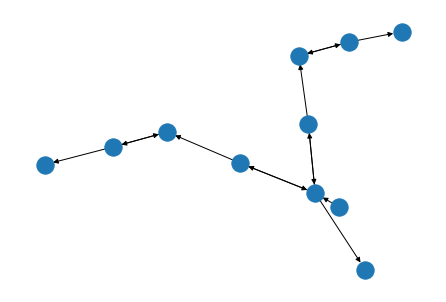

In [ ]:
G0 = nx.MultiDiGraph()
G0.add_node(1)
G0.add_node(2)
G0.add_node(3)
G0.add_node(4)
G0.add_node(5)
G0.add_node(6)
G0.add_node(7)
G0.add_node(8)
G0.add_node(9)
G0.add_node(10)
G0.add_node(11)


G0.add_edge(1, 2)
G0.add_edge(2, 3)
G0.add_edge(2, 4)
G0.add_edge(4, 2)
G0.add_edge(4, 5)
G0.add_edge(5, 6)
G0.add_edge(6, 5)
G0.add_edge(6, 7)

G0.add_edge(2, 8)
G0.add_edge(8, 2)
G0.add_edge(8, 9)
G0.add_edge(9, 10)
G0.add_edge(10, 9)
G0.add_edge(10, 11)

nx.draw(G0)
print("G0 number of nodes: ",G0.number_of_nodes())
print("G0 number of edges: ",G0.number_of_edges())

G1 number of nodes:  13
G1 number of edges:  18


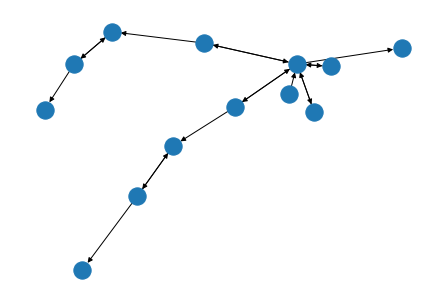

In [ ]:
G1 = nx.MultiDiGraph()
G1.add_node(1)
G1.add_node(2)
G1.add_node(3)
G1.add_node(4)
G1.add_node(5)
G1.add_node(6)
G1.add_node(7)
G1.add_node(8)
G1.add_node(9)
G1.add_node(10)
G1.add_node(11)
G1.add_node(12)
G1.add_node(13)

G1.add_edge(1, 2)
G1.add_edge(2, 3)
G1.add_edge(2, 4)
G1.add_edge(4, 2)
G1.add_edge(4, 5)
G1.add_edge(5, 6)
G1.add_edge(6, 5)
G1.add_edge(6, 7)

G1.add_edge(2, 8)
G1.add_edge(8, 2)
G1.add_edge(8, 9)
G1.add_edge(9, 10)
G1.add_edge(10, 9)
G1.add_edge(10, 11)
G1.add_edge(2, 12)
G1.add_edge(12, 2)
G1.add_edge(2, 13)
G1.add_edge(13, 2)

nx.draw(G1)
print("G1 number of nodes: ",G1.number_of_nodes())
print("G1 number of edges: ",G1.number_of_edges())

G1 number of nodes:  14
G1 number of edges:  19


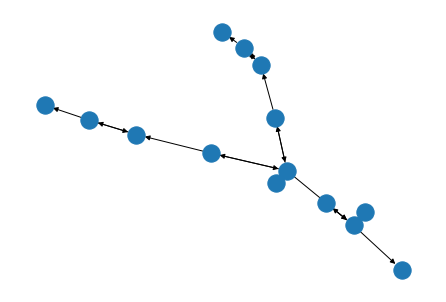

In [ ]:
G2 = nx.MultiDiGraph()
G2.add_node(1)
G2.add_node(2)
G2.add_node(3)
G2.add_node(4)
G2.add_node(5)
G2.add_node(6)
G2.add_node(7)
G2.add_node(8)
G2.add_node(9)
G2.add_node(10)
G2.add_node(11)
G2.add_node(12)
G2.add_node(13)
G2.add_node(14)

G2.add_edge(1, 2)
G2.add_edge(2, 3)
G2.add_edge(2, 4)
G2.add_edge(4, 2)
G2.add_edge(4, 5)
G2.add_edge(5, 6)
G2.add_edge(6, 5)
G2.add_edge(6, 7)

G2.add_edge(2, 8)
G2.add_edge(8, 2)
G2.add_edge(8, 9)
G2.add_edge(9, 10)
G2.add_edge(10, 9)
G2.add_edge(10, 11)
G2.add_edge(3, 12)
G2.add_edge(12, 3)
G2.add_edge(3, 13)
G2.add_edge(13, 3)
G2.add_edge(3, 14)

nx.draw(G2)
print("G1 number of nodes: ",G2.number_of_nodes())
print("G1 number of edges: ",G2.number_of_edges())

In [ ]:
PolymerE6_1 = Polymer(
   repeat_unit_smiles_list = ["*Sc1ccc(Sc2ccc(S*)cc2)cc1","*C=CCOCC(C)(COC/C=C/*)COC/C=C/*"],
 repeat_unit_smiles_level_list = [3,2], 
 end_group_smiles_list = None,
                      end_group_smiles_level_list = None, 
 graph_representation = G0  
)


PolymerE6_2 = Polymer(
   repeat_unit_smiles_list = ["*Sc1ccc(Sc2ccc(S*)cc2)cc1","*/C=C/c1ccc(N(c2ccc(/C=C/*)cc2)c2ccc(/C=C/*)cc2)cc1"],
 repeat_unit_smiles_level_list = [3,2], 
 end_group_smiles_list = None,
                      end_group_smiles_level_list = None, 
 graph_representation = G0  
)

PolymerE6_3 = Polymer(
   repeat_unit_smiles_list = ["*Sc1ccc(Sc2ccc(S*)cc2)cc1","*C=CCOCC(COC/C=C/*)(COC/C=C/*)COC/C=C/*"],
 repeat_unit_smiles_level_list = [4,2], 
 end_group_smiles_list = None,
 end_group_smiles_level_list = None, 
 graph_representation = G0  
)


PolymerE6_4 = Polymer(
    repeat_unit_smiles_list = ["*Sc1ccc(Sc2ccc(S*)cc2)cc1","*/C=C/c1ccc(C(=C(c2ccc(/C=C/*)cc2)c2ccc(/C=C/*)cc2)c2ccc(/C=C/*)cc2)cc1"],
    repeat_unit_smiles_level_list = [4,2], 
    end_group_smiles_list = None,
    end_group_smiles_level_list = None, 
    graph_representation = G0  
)




PolymerE6_5 = Polymer(
   repeat_unit_smiles_list = ["*/N=N/N(*)CCCCCCOc1ccc(OCCCCCCN(*)/N=N/*)cc1","*/C=C(\*)COCC(C)(COC/C(*)=C/*)COC/C(*)=C/*"],
 repeat_unit_smiles_level_list = [3,2], 
 end_group_smiles_list = None,
                      end_group_smiles_level_list = None, 
 graph_representation = G0  
)


PolymerE6_6 = Polymer(
   repeat_unit_smiles_list = ["*/N=N/N(*)CCCCCCOc1ccc(OCCCCCCN(*)/N=N/*)cc1","*/C=C(\*)c1ccc(N(c2ccc(/C(*)=C/*)cc2)c2ccc(/C(*)=C/*)cc2)cc1"],
 repeat_unit_smiles_level_list = [3,2], 
 end_group_smiles_list = None,
                      end_group_smiles_level_list = None, 
 graph_representation = G0  
)

PolymerE6_7 =Polymer(
   repeat_unit_smiles_list =  ["*/N=N/N(*)CCCCCCOc1ccc(OCCCCCCN(*)/N=N/*)cc1","*/C=C(\*)COCC(COC/C(*)=C/*)(COC/C(*)=C/*)COC/C(*)=C/*"],
 repeat_unit_smiles_level_list = [4,2], 
 end_group_smiles_list = None,
 end_group_smiles_level_list = None, 
 graph_representation = G0  
)


PolymerE6_8 = Polymer(
    repeat_unit_smiles_list = ["*/N=N/N(*)CCCCCCOc1ccc(OCCCCCCN(*)/N=N/*)cc1","*/C=C(\*)c1ccc(C(=C(c2ccc(/C(*)=C/*)cc2)c2ccc(/C(*)=C/*)cc2)c2ccc(/C(*)=C/*)cc2)cc1"],
    repeat_unit_smiles_level_list = [4,2], 
    end_group_smiles_list = None,
    end_group_smiles_level_list = None, 
    graph_representation = G0  
)



PolymerE6_9 = Polymer(
   repeat_unit_smiles_list = ["*/N=N/N(*)CCCCC(C)(C)C(=O)O*",
                              "*/N=N/N(*)CCCCC(C)(C)C(=O)*",
                              "*CCO*",
                              "*/C=C(\*)COCC(C)(COC/C(*)=C/*)COC/C(*)=C/*"],
 repeat_unit_smiles_level_list = [3,3,12,2], 
 end_group_smiles_list = None,
                      end_group_smiles_level_list = None, 
 graph_representation = G0  
)


PolymerE6_10 = Polymer(
   repeat_unit_smiles_list = ["*/N=N/N(*)CCCCC(C)(C)C(=O)O*",
                              "*/N=N/N(*)CCCCC(C)(C)C(=O)*",
                              "*CCO*",
                "*/C=C(\*)c1ccc(N(c2ccc(/C(*)=C/*)cc2)c2ccc(/C(*)=C/*)cc2)cc1"],
 repeat_unit_smiles_level_list = [3,3,12,2], 
 end_group_smiles_list = None,
                      end_group_smiles_level_list = None, 
 graph_representation = G0  
)

PolymerE6_11 = Polymer(
   repeat_unit_smiles_list = ["*/N=N/N(*)CCCCC(C)(C)C(=O)O*",
                              "*/N=N/N(*)CCCCC(C)(C)C(=O)*",
                              "*CCO*",
                "*/C=C(\*)COCC(COC/C(*)=C/*)(COC/C(*)=C/*)COC/C(*)=C/*"],
 repeat_unit_smiles_level_list = [4,4,16,2], 
 end_group_smiles_list = None,
 end_group_smiles_level_list = None, 
 graph_representation = G0  
)


PolymerE6_12 = Polymer(
    repeat_unit_smiles_list = ["*/N=N/N(*)CCCCC(C)(C)C(=O)O*",
                              "*/N=N/N(*)CCCCC(C)(C)C(=O)*",
                              "*CCO*",
                               "*/C=C(\*)c1ccc(C(=C(c2ccc(/C(*)=C/*)cc2)c2ccc(/C(*)=C/*)cc2)c2ccc(/C(*)=C/*)cc2)cc1"],
    repeat_unit_smiles_level_list = [4,4,16,2], 
    end_group_smiles_list = None,
    end_group_smiles_level_list = None, 
    graph_representation = G0  
)


In [ ]:
PolymerE6 = [PolymerE6_1, PolymerE6_2, PolymerE6_3, PolymerE6_4, 
             PolymerE6_5,PolymerE6_6, PolymerE6_7, PolymerE6_8, 
             PolymerE6_9,PolymerE6_10, PolymerE6_11, PolymerE6_12
             ]

In [ ]:
E6_RU_matrix = np.ones([12,12])
E6_TOP_matrix = np.ones([12,12])
E6_EG_matrix = np.ones([12,12])
E6_TOT_matrix = np.ones([12,12])

In [ ]:
for i in range(0,12):
    for j in range(0,12):
        STOTij, SRUij, STOPij = Similarity_Score_Two_Polymer(query = PolymerE6[i],
                             target = PolymerE6[j],
                             #level_weight = True,
                             #level_ratio = 3,
                             embedding_function = 'MorganFingerprint',
                             similarity_score_function = 'Tanimoto',
                             restrain_emd = False,
                             alpha=1,
                             Repeat_Unit_Weight=0.5,
                             Graph_Weight=0.5,
                             End_Group_Weight = 0.0,
                             Mean_Function = 'geometric',
                             details_print=True)
        E6_RU_matrix[i,j] = SRUij
        E6_RU_matrix[j,i] = SRUij

     


Details of the Similarity Score:

Similarity score on Repeating Unit =  1 , Weight for Repeating Unit =  0.5
Similarity score on Graph =  1.0 , Weight for Graph =  0.5
Similarity score on End Group =  None , Weight for End Group =  0.0
Similarity score Combined in geometric mean =  1.0


Query smiles list has different levels
Target smiles list has different levels
P1 ->Q1 0.0
P1 ->Q2 0.8620689655172413
P2 ->Q1 0.9696969696969697
P2 ->Q2 0.8857142857142857
Details of the Similarity Score:

Similarity score on Repeating Unit =  0.6457142857142857 , Weight for Repeating Unit =  0.5
Similarity score on Graph =  1.0 , Weight for Graph =  0.5
Similarity score on End Group =  None , Weight for End Group =  0.0
Similarity score Combined in geometric mean =  0.803563492024299


Query smiles list has different levels
Target smiles list has different levels
P1 ->Q1 0.0
P1 ->Q2 0.967741935483871
P2 ->Q1 0.9696969696969697
P2 ->Q2 0.34782608695652173
Details of the Similarity Score:

Similarity sc

In [ ]:
graphE6_details = np.array([20, 20, 28, 28,
                            20,20, 28,28,
                            34, 34, 42, 42])

In [ ]:
graph_edit_distance = np.ones([12,12])
for i in range(0,12):
    for j in range(i+1,12):
        if (graphE6_details[i]==28 and  graphE6_details[j]==34) or (graphE6_details[i]==34 and  graphE6_details[j]==28):
            graph_edit_distance[i,j] = 26
            graph_edit_distance[j,i] = 26
        else:
            graph_edit_distance[i,j] = abs(graphE6_details[j]-graphE6_details[i])
            graph_edit_distance[j,i] = abs(graphE6_details[j]-graphE6_details[i])
            print(graph_edit_distance[i,j])

                

0.0
8.0
8.0
0.0
0.0
8.0
8.0
14.0
14.0
22.0
22.0
8.0
8.0
0.0
0.0
8.0
8.0
14.0
14.0
22.0
22.0
0.0
8.0
8.0
0.0
0.0
14.0
14.0
8.0
8.0
0.0
0.0
14.0
14.0
0.0
8.0
8.0
14.0
14.0
22.0
22.0
8.0
8.0
14.0
14.0
22.0
22.0
0.0
14.0
14.0
14.0
14.0
0.0
8.0
8.0
8.0
8.0
0.0


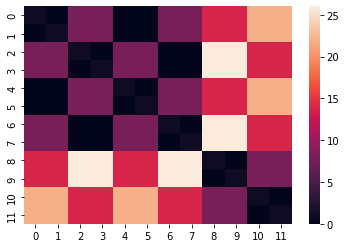

In [ ]:
sns.heatmap(graph_edit_distance)

In [ ]:
|

In [ ]:
for i in range(0,12):
    for j in range(i+1,12):
        E6_TOP_matrix[i,j] = np.exp(-1.0*graph_edit_distance[i,j]/(max(graphE6_details[i], graphE6_details[j]) - graph_edit_distance[i,j]))
        E6_TOP_matrix[j,i] = E6_TOP_matrix[i,j]
        print(graphE6_details[i], graphE6_details[j],graph_edit_distance[i,j] )


20 20 0.0
20 28 8.0
20 28 8.0
20 20 0.0
20 20 0.0
20 28 8.0
20 28 8.0
20 34 14.0
20 34 14.0
20 42 22.0
20 42 22.0
20 28 8.0
20 28 8.0
20 20 0.0
20 20 0.0
20 28 8.0
20 28 8.0
20 34 14.0
20 34 14.0
20 42 22.0
20 42 22.0
28 28 0.0
28 20 8.0
28 20 8.0
28 28 0.0
28 28 0.0
28 34 26.0
28 34 26.0
28 42 14.0
28 42 14.0
28 20 8.0
28 20 8.0
28 28 0.0
28 28 0.0
28 34 26.0
28 34 26.0
28 42 14.0
28 42 14.0
20 20 0.0
20 28 8.0
20 28 8.0
20 34 14.0
20 34 14.0
20 42 22.0
20 42 22.0
20 28 8.0
20 28 8.0
20 34 14.0
20 34 14.0
20 42 22.0
20 42 22.0
28 28 0.0
28 34 26.0
28 34 26.0
28 42 14.0
28 42 14.0
28 34 26.0
28 34 26.0
28 42 14.0
28 42 14.0
34 34 0.0
34 42 8.0
34 42 8.0
34 42 8.0
34 42 8.0
42 42 0.0


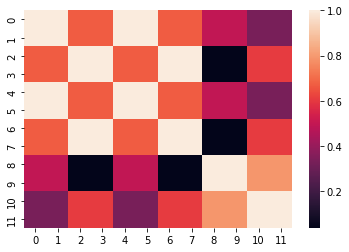

In [ ]:
sns.heatmap(E6_TOP_matrix)

In [ ]:
for i in range(0,12):
    for j in range(i+1,12):
          combination_score = pow(E6_RU_matrix[i,j], 0.5) * pow(E6_TOP_matrix[i,j], 0.5)
          E6_TOT_matrix[i,j] = combination_score
          E6_TOT_matrix[j,i] = combination_score


In [ ]:
STOT12, SRU12, STOP12= Similarity_Score_Two_Polymer(query = PolymerE6[0],
                             target = PolymerE6[11],
                             #level_weight = True,
                             #level_ratio = 3,
                             embedding_function = 'MorganFingerprint',
                             similarity_score_function = 'Tanimoto',
                             restrain_emd = False,
                             alpha=1,
                             Repeat_Unit_Weight=0.5,
                             Graph_Weight=0.5,
                             End_Group_Weight = 0.0,
                             Mean_Function = 'geometric',
                             details_print=True)

Query smiles list has different levels
Target smiles list has different levels
P1 ->Q1 0.9782608695652174
P1 ->Q2 0.9767441860465116
P1 ->Q3 0.9583333333333334
P1 ->Q4 0.8571428571428572
P2 ->Q1 0.8723404255319149
P2 ->Q2 0.8888888888888888
P2 ->Q3 0.8928571428571429
P2 ->Q4 0.9142857142857143
Details of the Similarity Score:

Similarity score on Repeating Unit =  0.07940795423302938 , Weight for Repeating Unit =  0.5
Similarity score on Graph =  1.0 , Weight for Graph =  0.5
Similarity score on End Group =  None , Weight for End Group =  0.0
Similarity score Combined in geometric mean =  0.28179416997700535




In [ ]:
np.sqrt(E6_RU_matrix[0,10])

0.28742491117918567

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

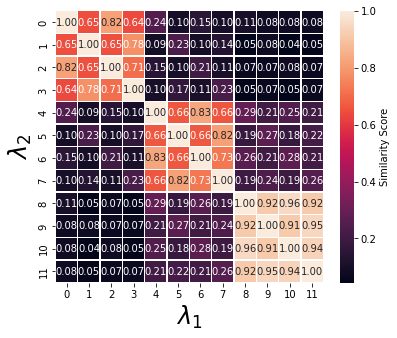

In [ ]:
fig,ax = plt.subplots(figsize=(6,5))

ax = sns.heatmap(E6_RU_matrix, linewidth=0.3, annot=True, fmt=".2f" , cbar_kws={'label': 'Similarity Score'})


ax.set_xlabel(r"$\lambda_1$", size =24)
ax.set_ylabel(r"$\lambda_2$", size = 24)
resolution_value = 1200
#plt.savefig("myImage_heatmap.png", format="png", dpi=resolution_value , bbox_inches='tight')

plt.show()

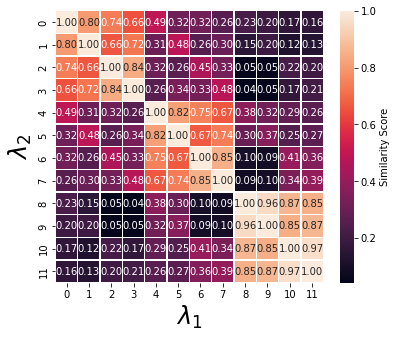

In [ ]:
fig,ax = plt.subplots(figsize=(6,5))

ax = sns.heatmap(E6_TOT_matrix, linewidth=0.3, annot=True, fmt=".2f" , cbar_kws={'label': 'Similarity Score'})

ax.set_xlabel(r"$\lambda_1$", size =24)
ax.set_ylabel(r"$\lambda_2$", size = 24)
resolution_value = 1200
#plt.savefig("myImage_heatmap.png", format="png", dpi=resolution_value , bbox_inches='tight')

plt.show()

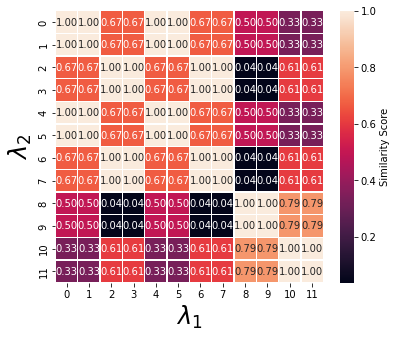

In [ ]:

fig,ax = plt.subplots(figsize=(6,5))

ax = sns.heatmap(E6_TOP_matrix, linewidth=0.3, annot=True, fmt=".2f" , cbar_kws={'label': 'Similarity Score'})


ax.set_xlabel(r"$\lambda_1$", size =24)
ax.set_ylabel(r"$\lambda_2$", size = 24)
resolution_value = 1200
#plt.savefig("myImage_heatmap.png", format="png", dpi=resolution_value , bbox_inches='tight')

plt.show()

In [ ]:
from scipy import io

In [ ]:
io.savemat("E6_TOT_matrix.mat", {"E6_TOT_matrix": E6_TOT_matrix})
io.savemat("E6_RU_matrix.mat", {"E6_RU_matrix": E6_RU_matrix})
io.savemat("E6_TOP_matrix.mat", {"E6_TOP_matrix": E6_TOP_matrix})


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os

Mounted at /content/gdrive


In [ ]:
path = "gdrive/My Drive/Poly"
os.mkdir(path)

FileNotFoundError: ignored

In [ ]:
import numpy as np

In [ ]:
np.exp(-26/8)

0.03877420783172201